In [2]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


We recorded the size of the PB / AVRO messages after serialization:

- Simple:
    - Avro: 100018 bytes
    - Protobuf: 100015 bytes
    - Capnproto: 100064
    - Thrift: 100019
- Complex:
    - Avro: 878 bytes
    - Protobuf: 1200 bytes
    - Capnproto: 2848 bytes
    - Thrift: 877 bytes
- Nested:
    - Avro: 30 bytes
    - Protobuf: 30 bytes
    - Capnproto: 100088 bytes
    - Thrift: 100031 bytes

In [3]:
binary_formats = ["PB", "AVRO", "CAPNPROTO", "THRIFT"]
message_types = [1, 2, 3]
message_types_string = ["simple", "complex", "nested"]
message_nums = [10, 100, 1000, 10000, 100000, 1000000]

In [4]:
message_combos = list(itertools.product(message_types, message_nums))
all_dataframes = {}

In [5]:
for bin_type in binary_formats:
    for msg_type, msg_num in message_combos:
        try:
            # Read into dataframe
            df = pd.read_csv(f"{bin_type}{msg_type}_{msg_num}_serdes.csv", header=None)
            
            # Calculate stats
            ser_mean, deser_mean = list(df.mean(axis=0))
            ser_median, deser_median = list(df.median(axis=0))
            
            ser_10p, deser_10p = list(df.quantile(0.1))
            ser_90p, deser_90p = list(df.quantile(0.9))
            
            ser_25p, deser_25p = list(df.quantile(0.25))
            ser_75p, deser_75p = list(df.quantile(0.75))
            
            # Store
            all_dataframes[(bin_type, msg_type, msg_num)] = {}
            all_dataframes[(bin_type, msg_type, msg_num)]["ser"] = {
                "mean": ser_mean,
                "median": ser_median,
                "10p": ser_10p,
                "90p": ser_90p,
                "25p": ser_25p,
                "75p": ser_75p,
            }
            all_dataframes[(bin_type, msg_type, msg_num)]["deser"] = {
                "mean": deser_mean,
                "median": deser_median,
                "10p": deser_10p,
                "90p": deser_90p,
                "25p": deser_25p,
                "75p": deser_75p,
            }
        except:
            print(bin_type, msg_type, msg_num)

CAPNPROTO 1 10
CAPNPROTO 1 100
CAPNPROTO 1 1000
CAPNPROTO 1 10000
CAPNPROTO 1 100000
CAPNPROTO 1 1000000
CAPNPROTO 2 10
CAPNPROTO 2 100
CAPNPROTO 2 1000
CAPNPROTO 2 10000
CAPNPROTO 2 100000
CAPNPROTO 2 1000000
CAPNPROTO 3 10
CAPNPROTO 3 100
CAPNPROTO 3 1000
CAPNPROTO 3 10000
CAPNPROTO 3 100000
CAPNPROTO 3 1000000
THRIFT 1 10
THRIFT 1 100
THRIFT 1 1000
THRIFT 1 10000
THRIFT 1 100000
THRIFT 1 1000000
THRIFT 2 10
THRIFT 2 100
THRIFT 2 1000
THRIFT 2 10000
THRIFT 2 100000
THRIFT 2 1000000
THRIFT 3 10
THRIFT 3 100
THRIFT 3 1000
THRIFT 3 10000
THRIFT 3 100000
THRIFT 3 1000000


In [6]:
all_dataframes[("PB", 1, 100000)]

{'ser': {'mean': 4608.90629,
  'median': 1014.0,
  '10p': 867.0,
  '90p': 4091.100000000006,
  '25p': 921.0,
  '75p': 1336.0},
 'deser': {'mean': 1854.75398,
  'median': 324.0,
  '10p': 260.0,
  '90p': 1154.0,
  '25p': 290.0,
  '75p': 600.25}}

6 6
6 6


KeyError: ('CAPNPROTO', 1, 10)

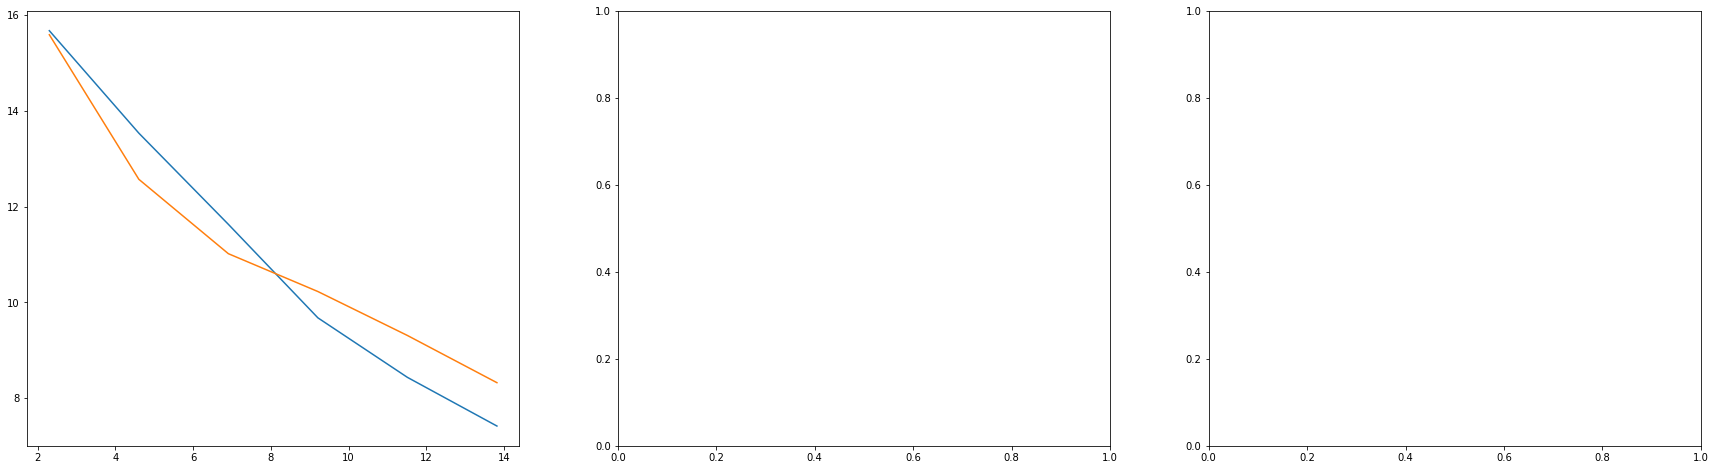

In [17]:
logplot = True
fig, axs = plt.subplots(1, 3, figsize=(30, 8))
for idx, msg_type in enumerate(message_types):
    for bin_type in binary_formats:
        temp = [all_dataframes[(bin_type, msg_type, num)]["ser"]["mean"] for num in message_nums]
        lower_percentile = [all_dataframes[(bin_type, msg_type, num)]["ser"]["25p"] for num in message_nums]
        higher_percentile = [all_dataframes[(bin_type, msg_type, num)]["ser"]["75p"] for num in message_nums]
        low_err = np.array(temp) - np.array(lower_percentile)
        high_err = np.array(temp) - np.array(higher_percentile)

        print(len(message_nums), len(temp))
        
        if logplot:
            axs[idx].plot(np.log(message_nums),
                         np.log(temp),
    #                      yerr=[np.log(low_err), np.log(high_err)],
#                          fmt="-o",
                         label=f"{bin_type}, {message_types_string[msg_type-1]} messages")
        else:
            axs[idx].plot(message_nums,
                         temp,
    #                      yerr=[low_err, high_err],
#                          fmt="o",
                         label=f"{bin_type}, {message_types_string[msg_type-1]} messages")

    axs[idx].set_title(f'{message_type_strings[idx]}')
    axs[idx].legend()
    axs[idx].xlabel("Number of Messages (log)")
    axs[idx].ylabel("Mean Serialization Time (log ns)")
plt.show()

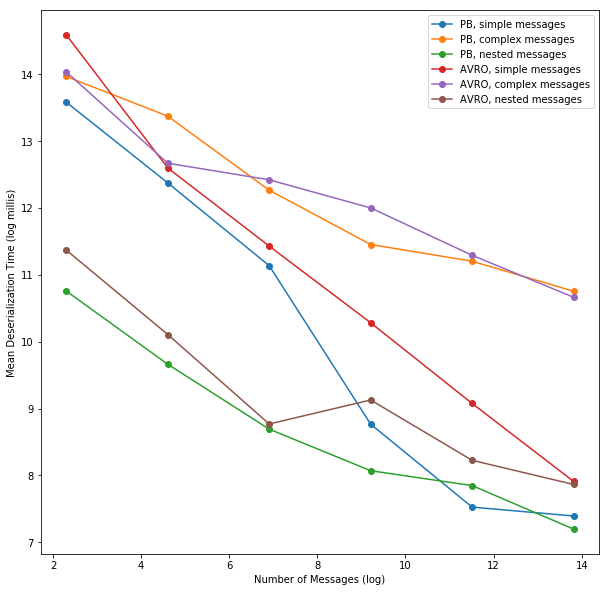

In [7]:
logplot = True

plt.figure(figsize=(10, 10))
for bin_type, msg_type in itertools.product(binary_formats, message_types):
    temp = [all_dataframes[(bin_type, msg_type, num)]["deser"]["mean"] for num in message_nums]
    lower_percentile = [all_dataframes[(bin_type, msg_type, num)]["deser"]["25p"] for num in message_nums]
    higher_percentile = [all_dataframes[(bin_type, msg_type, num)]["deser"]["75p"] for num in message_nums]
    low_err = np.array(temp) - np.array(lower_percentile)
    high_err = np.array(temp) - np.array(higher_percentile)
    
    if logplot:
        plt.errorbar(np.log(message_nums),
                     np.log(temp),
#                      yerr=[np.log(low_err), np.log(high_err)],
                     fmt="-o",
                     label=f"{bin_type}, {message_types_string[msg_type-1]} messages")
    else:
        plt.errorbar(message_nums,
                     temp,
#                      yerr=[low_err, high_err],
                     fmt="o",
                     label=f"{bin_type}, {message_types_string[msg_type-1]} messages")
plt.legend()
plt.xlabel("Number of Messages (log)")
plt.ylabel("Mean Deserialization Time (log millis)")
plt.show()

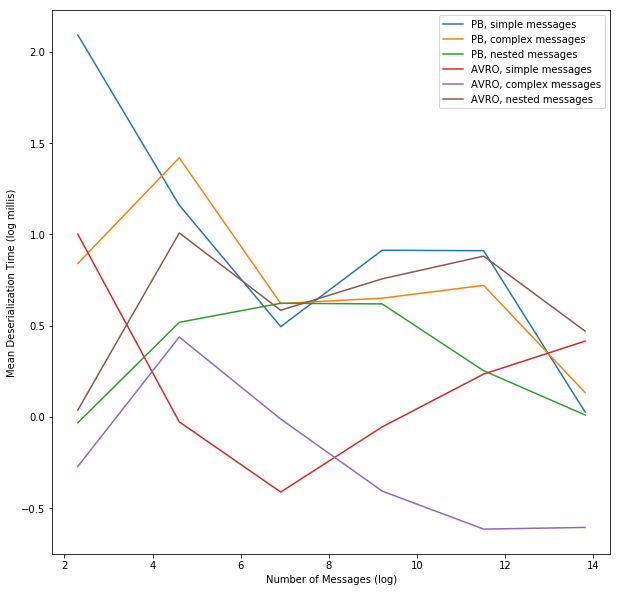

In [30]:
logplot = True

plt.figure(figsize=(10, 10))
for bin_type, msg_type in itertools.product(binary_formats, message_types):
    ser_time = np.array([all_dataframes[(bin_type, msg_type, num)]["ser"]["mean"] for num in message_nums])
    deser_time = np.array([all_dataframes[(bin_type, msg_type, num)]["deser"]["mean"] for num in message_nums])
    
    if logplot:
        ser_log = np.log(ser_time)
        deser_log = np.log(deser_time)
    
        plt.plot(np.log(message_nums),
                     ser_log - deser_log,
#                      yerr=[np.log(low_err), np.log(high_err)],
#                      fmt="-",
                     label=f"{bin_type}, {message_types_string[msg_type-1]} messages")
        plt.plot(x = 0)
    else:
        plt.plot(message_nums,
                     ser_time - deser_time,
#                      yerr=[low_err, high_err],
#                      fmt="-",
                     label=f"{bin_type}, {message_types_string[msg_type-1]} messages")
plt.legend()
plt.xlabel("Number of Messages (log)")
plt.ylabel("Mean Deserialization Time (log millis)")
plt.show()

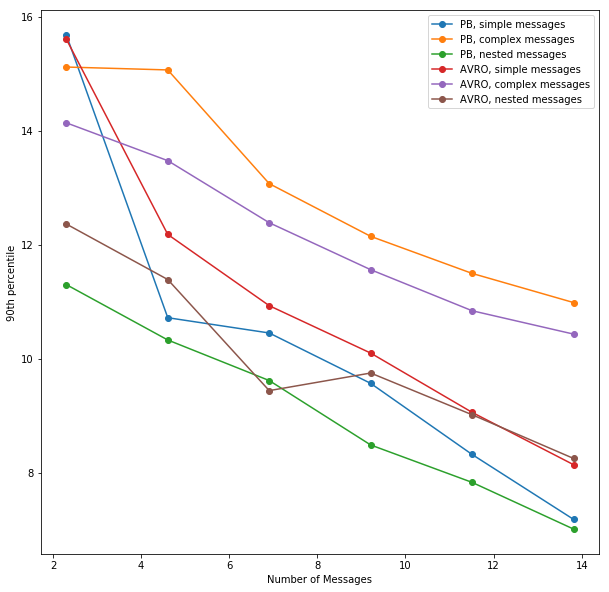

In [41]:
logplot = True

plt.figure(figsize=(10, 10))
for bin_type, msg_type in itertools.product(binary_formats, message_types):
    temp = [all_dataframes[(bin_type, msg_type, num)]["ser"]["median"] for num in message_nums]
    lower_percentile = [all_dataframes[(bin_type, msg_type, num)]["ser"]["25p"] for num in message_nums]
    higher_percentile = [all_dataframes[(bin_type, msg_type, num)]["ser"]["90p"] for num in message_nums]
    low_err = np.array(temp) - np.array(lower_percentile)
    high_err = np.array(temp) - np.array(higher_percentile)
    
    plt.errorbar(np.log(message_nums),
                 np.log(higher_percentile),
                 fmt="-o",
                 label=f"{bin_type}, {message_types_string[msg_type-1]} messages")

plt.legend()
plt.xlabel("Number of Messages")
plt.ylabel("90th percentile")
plt.show()

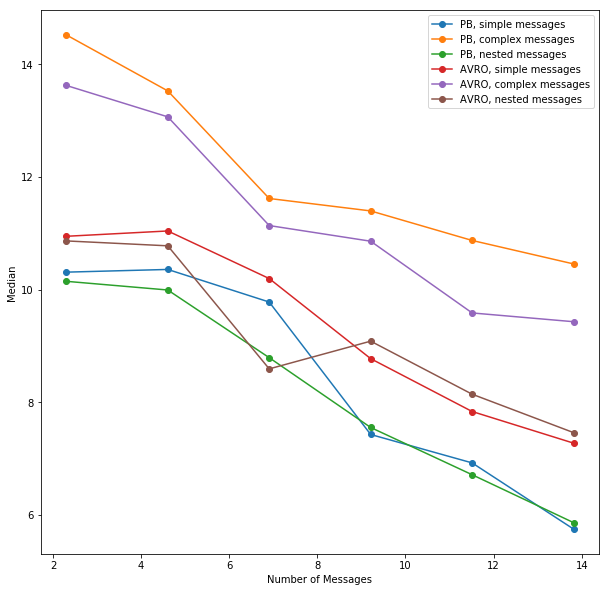

In [43]:
logplot = True

plt.figure(figsize=(10, 10))
for bin_type, msg_type in itertools.product(binary_formats, message_types):
    temp = [all_dataframes[(bin_type, msg_type, num)]["ser"]["median"] for num in message_nums]
    lower_percentile = [all_dataframes[(bin_type, msg_type, num)]["ser"]["25p"] for num in message_nums]
    higher_percentile = [all_dataframes[(bin_type, msg_type, num)]["ser"]["90p"] for num in message_nums]
    low_err = np.array(temp) - np.array(lower_percentile)
    high_err = np.array(temp) - np.array(higher_percentile)
    
    plt.errorbar(np.log(message_nums),
                 np.log(temp),
                 fmt="-o",
                 label=f"{bin_type}, {message_types_string[msg_type-1]} messages")

plt.legend()
plt.xlabel("Number of Messages")
plt.ylabel("Median")
plt.show()